In [14]:
# Cell 1: Install & Import Libraries
!pip install datasets scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import re


In [19]:
# =======================
# Cell 2: Load Datasets
# =======================

from datasets import load_dataset
import pandas as pd

# -----------------------
# 1. News dataset (AG News)
# -----------------------
news_dataset = load_dataset("ag_news", split="train[:12000]")   # small subset for Colab
news_df = news_dataset.to_pandas()[["text", "label"]]
news_df["title"] = news_df["text"].apply(lambda x: x.split(".")[0])   # crude title extraction
news_df["label"] = news_df["label"].map({0:"World",1:"Sports",2:"Business",3:"Sci/Tech"})
news_df["source"] = "News"
news_df = news_df[["title","text","label","source"]]

# -----------------------
# 2. Research dataset (arXiv abstracts)
# -----------------------
arxiv_dataset = load_dataset("gfissore/arxiv-abstracts-2021", split="train[:5000]")  # keep it small
arxiv_df = arxiv_dataset.to_pandas()[["title","abstract","categories"]]

# Combine title + abstract
arxiv_df["text"] = arxiv_df["title"].fillna("") + " " + arxiv_df["abstract"].fillna("")

# Fix category extraction (categories is a list/array)
arxiv_df["label"] = arxiv_df["categories"].apply(lambda cats: cats[0] if isinstance(cats, (list, tuple, np.ndarray)) else str(cats))

arxiv_df["source"] = "Research"
arxiv_df = arxiv_df[["title","text","label","source"]]

# -----------------------
# 3. Merge
# -----------------------
data = pd.concat([news_df, arxiv_df], ignore_index=True)
print("Combined shape:", data.shape)
print(data["source"].value_counts())
print(data["label"].value_counts().head(10))
data.head()



Combined shape: (17000, 4)
source
News        12000
Research     5000
Name: count, dtype: int64
label
Sci/Tech             3196
Business             3039
World                2976
Sports               2789
astro-ph              915
hep-ph                231
quant-ph              205
hep-th                193
cond-mat.mtrl-sci     111
gr-qc                 107
Name: count, dtype: int64


,title,text,label,source
0,Wall St,Wall St. Bears Claw Back Into the Black (Reute...,Business,News
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Carlyle Looks Toward Commercial Aerospace (Reu...,Business,News
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,Oil and Economy Cloud Stocks' Outlook (Reuters...,Business,News
3,Iraq Halts Oil Exports from Main Southern Pipe...,Iraq Halts Oil Exports from Main Southern Pipe...,Business,News
4,"Oil prices soar to all-time record, posing new...","Oil prices soar to all-time record, posing new...",Business,News


In [20]:
# Cell 3: Clean text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z]", " ", text)  # only letters
    return text.lower()

data["clean_text"] = (data["title"] + " " + data["text"]).apply(clean_text)

# Encode labels
le = LabelEncoder()
data["label_encoded"] = le.fit_transform(data["label"])

print("Unique Topics:", len(le.classes_))
print("Classes:", list(le.classes_))
data.head()


Unique Topics: 947
Classes: ['Business', 'Sci/Tech', 'Sports', 'World', 'astro-ph', 'astro-ph gr-qc', 'astro-ph gr-qc hep-ph', 'astro-ph gr-qc hep-ph hep-th', 'astro-ph gr-qc hep-ph nucl-th', 'astro-ph gr-qc hep-th', 'astro-ph gr-qc math.AP', 'astro-ph gr-qc nucl-th', 'astro-ph hep-ex', 'astro-ph hep-ph', 'astro-ph hep-ph hep-th', 'astro-ph hep-ph nucl-th', 'astro-ph hep-ph physics.atom-ph physics.space-ph', 'astro-ph hep-th', 'astro-ph hep-th physics.atom-ph', 'astro-ph math-ph math.MP', 'astro-ph math.DS nlin.CD', 'astro-ph nlin.CD physics.plasm-ph physics.space-ph', 'astro-ph nucl-ex nucl-th', 'astro-ph nucl-th', 'astro-ph physics.ao-ph', 'cond-mat.dis-nn', 'cond-mat.dis-nn astro-ph cond-mat.other nlin.AO q-bio.NC', 'cond-mat.dis-nn cond-mat.mes-hall', 'cond-mat.dis-nn cond-mat.mtrl-sci', 'cond-mat.dis-nn cond-mat.soft', 'cond-mat.dis-nn cond-mat.soft cond-mat.stat-mech', 'cond-mat.dis-nn cond-mat.soft hep-ph', 'cond-mat.dis-nn cond-mat.stat-mech', 'cond-mat.dis-nn cond-mat.stat-mec

,title,text,label,source,clean_text,label_encoded
0,Wall St,Wall St. Bears Claw Back Into the Black (Reute...,Business,News,wall st wall st bears claw back into the blac...,0
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Carlyle Looks Toward Commercial Aerospace (Reu...,Business,News,carlyle looks toward commercial aerospace reu...,0
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,Oil and Economy Cloud Stocks' Outlook (Reuters...,Business,News,oil and economy cloud stocks outlook reuters...,0
3,Iraq Halts Oil Exports from Main Southern Pipe...,Iraq Halts Oil Exports from Main Southern Pipe...,Business,News,iraq halts oil exports from main southern pipe...,0
4,"Oil prices soar to all-time record, posing new...","Oil prices soar to all-time record, posing new...",Business,News,oil prices soar to all time record posing new...,0


In [23]:
# =======================
# Cell 4: Train-Test Split + TF-IDF (Fixed)
# =======================

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re
import numpy as np

# 1. Clean text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z]", " ", text)
    return text.lower()

data["clean_text"] = (data["title"] + " " + data["text"]).apply(clean_text)

# 2. Filter rare classes (keep classes with >=20 samples)
class_counts = data["label"].value_counts()
valid_classes = class_counts[class_counts >= 20].index
data = data[data["label"].isin(valid_classes)].reset_index(drop=True)

# 3. Encode labels
le = LabelEncoder()
data["label_encoded"] = le.fit_transform(data["label"])
print("Classes used:", le.classes_)

# 4. Train-test split with stratify
X_train, X_test, y_train, y_test = train_test_split(
    data["clean_text"], data["label_encoded"], test_size=0.2, random_state=42, stratify=data["label_encoded"]
)

# 5. TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=8000, stop_words="english")
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print("TF-IDF train shape:", X_train.shape)
print("TF-IDF test shape:", X_test.shape)


Classes used: ['Business' 'Sci/Tech' 'Sports' 'World' 'astro-ph' 'cond-mat.mes-hall'
 'cond-mat.mtrl-sci' 'cond-mat.other' 'cond-mat.soft'
 'cond-mat.soft cond-mat.stat-mech' 'cond-mat.stat-mech' 'cond-mat.str-el'
 'cond-mat.supr-con' 'cond-mat.supr-con cond-mat.str-el' 'cs.IT math.IT'
 'gr-qc' 'hep-ex' 'hep-ph' 'hep-ph hep-ex' 'hep-th' 'hep-th gr-qc'
 'math-ph math.MP' 'math.AG' 'math.AP' 'math.CO' 'math.DG' 'math.DS'
 'math.NT' 'math.PR' 'nucl-ex' 'nucl-th' 'physics.atom-ph'
 'physics.gen-ph' 'physics.optics' 'quant-ph']
TF-IDF train shape: (11910, 8000)
TF-IDF test shape: (2978, 8000)


In [24]:
# Cell 5: Baseline
baseline = LogisticRegression(max_iter=200)
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

print("Baseline (Logistic Regression) Report:\n")
print(classification_report(y_test, y_pred_base, target_names=le.classes_))


Baseline (Logistic Regression) Report:

                                   precision    recall  f1-score   support

                         Business       0.87      0.88      0.87       608
                         Sci/Tech       0.79      0.90      0.84       639
                           Sports       0.89      0.97      0.93       558
                            World       0.89      0.86      0.87       595
                         astro-ph       0.70      0.98      0.82       183
                cond-mat.mes-hall       0.75      0.50      0.60        18
                cond-mat.mtrl-sci       0.60      0.14      0.22        22
                   cond-mat.other       0.00      0.00      0.00        10
                    cond-mat.soft       0.00      0.00      0.00         7
 cond-mat.soft cond-mat.stat-mech       0.00      0.00      0.00         4
               cond-mat.stat-mech       1.00      0.23      0.38        13
                  cond-mat.str-el       0.82      0.50     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
# Cell 6: Compare Multiple Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted"),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "F1 Score": f1_score(y_test, y_pred, average="weighted")
    }

results_df = pd.DataFrame(results).T
results_df


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.835124,0.812745,0.835124,0.813312
Naive Bayes,0.802216,0.778918,0.802216,0.777111
Linear SVM,0.856279,0.852955,0.856279,0.852507
Random Forest,0.777367,0.752202,0.777367,0.751356


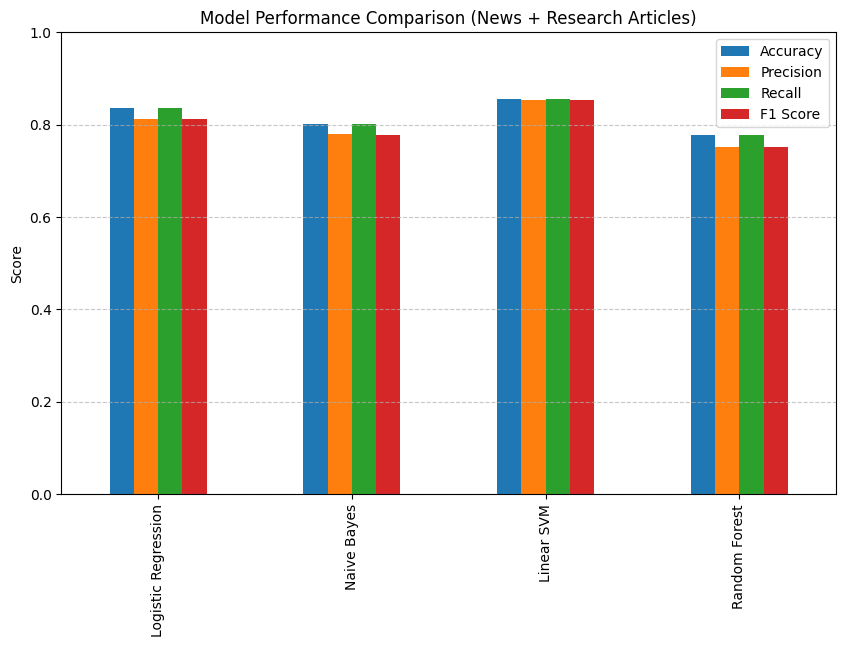

In [26]:
# Cell 7: Performance Comparison Graph
results_df[["Accuracy","Precision","Recall","F1 Score"]].plot(kind="bar", figsize=(10,6))
plt.title("Model Performance Comparison (News + Research Articles)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


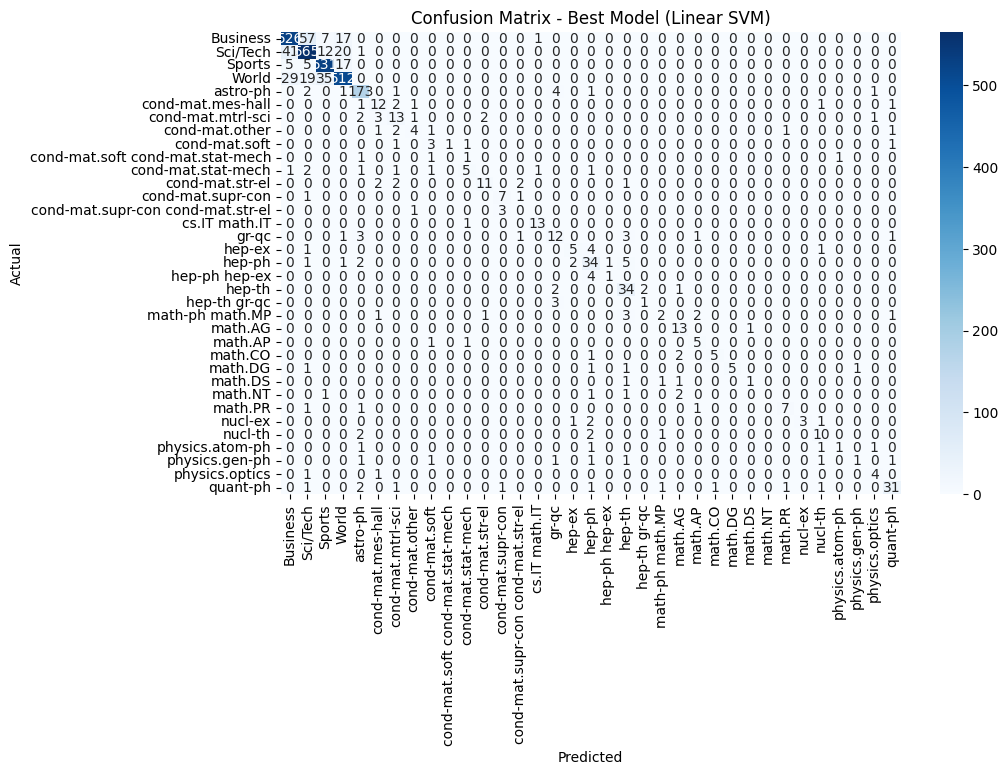

In [27]:
# Cell 8: Confusion Matrix for Best Model (likely Linear SVM)
best_model = LinearSVC()
best_model.fit(X_train, y_train)
y_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_best)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best Model (Linear SVM)")
plt.show()
